

# RF-DETR Model Training Notebook on Medical Equipment Detection Dataset

---

RF-DETR is a real-time, transformer-based object detection model architecture developed by Roboflow and released under the Apache 2.0 license.

![rf-detr-coco-rf100-vl-8](https://media.roboflow.com/rfdetr/pareto.png)

The RF-DETR family of models stands as the quickest and most precise in object detection across all sizes. RF-DETR has achieved over 60 mAP on the Microsoft COCO benchmark, a leading measure of object detection performance. It also sets new records on RF100-VL, a benchmark that shows how well models adapt to real-world problems beyond standard datasets.

The RF-DETR model group includes five sizes: Nano, Small, Medium, Base, and Large. These models offer a range of options for different needs. For example, RF-DETR-Nano is 11 mAP higher than YOLO11-n (on mAP50:95) and runs 0.17 ms faster. Likewise, RF-DETR-Small is 1.8 mAP better than YOLO11-x (the biggest YOLO11 model) and speeds things up by a good 7.77 ms. This wide range of models makes RF-DETR a great choice for many real-world uses, from small devices that need to be super fast to bigger jobs that demand top precision.

RF-DETR is small enough to run on edge devices, making it perfect for deployments that need both high accuracy and real-time performance. You can easily get started with any of the RF-DETR models, as they're ready for training in the cloud with Roboflow or through the free RF-DETR Python package.

## Environment setup

### Configure API Key

To fine-tune RF-DETR, you need to provide your Roboflow API key. Follow these steps:

- Go to your [`Roboflow Settings`](https://app.roboflow.com/settings/api) page. Click `Copy` to copy your private API key.
- In Colab, go to the left pane and click on `Secrets` (🔑).
    - Store your Roboflow API Key under the name `ROBOFLOW_API_KEY`.

In [ ]:
import os
from google.colab import userdata

os.environ["ROBOFLOW_API_KEY"] = ""

### Check GPU availability

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `T4 GPU`, and then click `Save`.

In [ ]:
!nvidia-smi

Fri Sep 26 10:32:22 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   32C    P0             56W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Install dependencies

Installs RF-DETR version 1.2.1 or higher (which includes the new Nano, Small, and Medium checkpoints), along with Supervision for benchmarking and Roboflow for pulling datasets and uploading models to the Roboflow platform.

In [ ]:
!pip install -q rfdetr==1.2.1 supervision==0.26.1 roboflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.3/266.3 kB 20.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.3/131.3 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.2/207.2 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.7/88.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 51.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 119.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 372.8/372.8 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Download example data

Downloads example images for testing. You can use these or replace them with your own images.

In [ ]:
!wget -q https://media.roboflow.com/notebooks/examples/dog-2.jpeg
!wget -q https://media.roboflow.com/notebooks/examples/dog-3.jpeg

## Inference with Pre-trained COCO Model

Runs inference on an example image using a pretrained RF-DETR Medium model (trained on COCO). To use a different model size, simply replace `RFDETRMedium` with `RFDETRNano`, `RFDETRSmall`, `RFDETRBase` or `RFDETRLarge` as needed.

rf-detr-medium.pth: 100%|██████████| 386M/386M [00:18<00:00, 22.5MiB/s]


Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


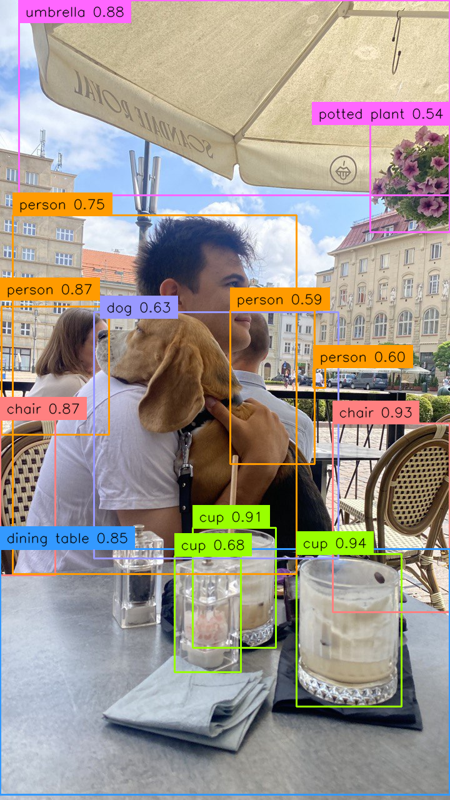

In [ ]:
import numpy as np
import supervision as sv

from PIL import Image

from rfdetr import RFDETRMedium
from rfdetr.util.coco_classes import COCO_CLASSES

image = Image.open("dog-2.jpeg")

model = RFDETRMedium(resolution=640)
model.optimize_for_inference()

detections = model.predict(image, threshold=0.5)

color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff8080", "#ff66b2", "#ff66ff", "#b266ff",
    "#9999ff", "#3399ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])
text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(color=color, thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    smart_position=True
)

labels = [
    f"{COCO_CLASSES[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotated_image = image.copy()
annotated_image = bbox_annotator.annotate(annotated_image, detections)
annotated_image = label_annotator.annotate(annotated_image, detections, labels)
annotated_image.thumbnail((800, 800))
annotated_image

## Download Dataset from Roboflow Universe

RF-DETR expects the dataset to be in COCO format. Divide your dataset into three subdirectories: `train`, `valid`, and `test`. Each subdirectory should contain its own `_annotations.coco.json` file that holds the annotations for that particular split, along with the corresponding image files. Below is an example of the directory structure:

```
dataset/
├── train/
│   ├── _annotations.coco.json
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ... (other image files)
├── valid/
│   ├── _annotations.coco.json
│   ├── image1.jpg
│   ├── image2.jpg
│   └── ... (other image files)
└── test/
    ├── _annotations.coco.json
    ├── image1.jpg
    ├── image2.jpg
    └── ... (other image files)
```

[Roboflow](https://roboflow.com/annotate) allows you to create object detection datasets from scratch or convert existing datasets from formats like YOLO, and then export them in COCO JSON format for training. You can also explore [Roboflow Universe](https://universe.roboflow.com/) to find pre-labeled datasets for a range of use cases.

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="")
project = rf.workspace(").project("")
version = project.version(2)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to medical-first-aid-equipment-30-2 in coco:: 100%|██████████| 4512/4512 [00:00<00:00, 5938.74it/s]


## Train RF-DETR on custom dataset

### Choose the right `batch_size`

Different GPUs have different amounts of VRAM (video memory), which limits how much data they can handle at once during training. To make training work well on any machine, you can adjust two settings: `batch_size` and `grad_accum_steps`. These control how many samples are processed at a time. The key is to keep their product equal to 16 — that’s our recommended total batch size. For example, on powerful GPUs like the A100, set `batch_size=16` and `grad_accum_steps=1`. On smaller GPUs like the T4, use `batch_size=4` and `grad_accum_steps=4`. We use a method called gradient accumulation, which lets the model simulate training with a larger batch size by gradually collecting updates before adjusting the weights.

In [ ]:
from rfdetr import RFDETRMedium

model = RFDETRMedium()

model.train(dataset_dir=dataset.location, epochs=30, batch_size=16, grad_accum_steps=2)

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Loading pretrain weights


reinitializing your detection head with 31 classes.


TensorBoard logging initialized. To monitor logs, use 'tensorboard --logdir output' and open http://localhost:6006/ in browser.
Not using distributed mode
git:
  sha: N/A, status: clean, branch: N/A

Namespace(num_classes=31, grad_accum_steps=2, amp=True, lr=0.0001, lr_encoder=0.00015, batch_size=16, weight_decay=0.0001, epochs=30, lr_drop=100, clip_max_norm=0.1, lr_vit_layer_decay=0.8, lr_component_decay=0.7, do_benchmark=False, dropout=0, drop_path=0.0, drop_mode='standard', drop_schedule='constant', cutoff_epoch=0, pretrained_encoder=None, pretrain_weights='rf-detr-medium.pth', pretrain_exclude_keys=None, pretrain_keys_modify_to_load=None, pretrained_distiller=None, encoder='dinov2_windowed_small', vit_encoder_num_layers=12, window_block_indexes=None, position_embedding='sine', out_feature_indexes=[3, 6, 9, 12], freeze_encoder=False, layer_norm=True, rms_norm=False, backbone_lora=False, force_no_pretrain=False, dec_layers=4, dim_feedforward=2048, hidden_dim=256, sa_nheads=8, ca_nhea

Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:306.)
Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an erro

Epoch: [0]  [ 0/98]  eta: 0:06:00  lr: 0.000100  class_error: 98.01  loss: 12.7086 (12.7086)  loss_ce: 1.0281 (1.0281)  loss_bbox: 0.6593 (0.6593)  loss_giou: 0.7612 (0.7612)  loss_ce_0: 0.9771 (0.9771)  loss_bbox_0: 0.7715 (0.7715)  loss_giou_0: 0.8602 (0.8602)  loss_ce_1: 1.0090 (1.0090)  loss_bbox_1: 0.7080 (0.7080)  loss_giou_1: 0.8010 (0.8010)  loss_ce_2: 1.0217 (1.0217)  loss_bbox_2: 0.6873 (0.6873)  loss_giou_2: 0.7766 (0.7766)  loss_ce_enc: 0.9753 (0.9753)  loss_bbox_enc: 0.8062 (0.8062)  loss_giou_enc: 0.8661 (0.8661)  loss_ce_unscaled: 1.0281 (1.0281)  class_error_unscaled: 98.0057 (98.0057)  loss_bbox_unscaled: 0.1319 (0.1319)  loss_giou_unscaled: 0.3806 (0.3806)  cardinality_error_unscaled: 3841.2500 (3841.2500)  loss_ce_0_unscaled: 0.9771 (0.9771)  loss_bbox_0_unscaled: 0.1543 (0.1543)  loss_giou_0_unscaled: 0.4301 (0.4301)  cardinality_error_0_unscaled: 3857.1250 (3857.1250)  loss_ce_1_unscaled: 1.0090 (1.0090)  loss_bbox_1_unscaled: 0.1416 (0.1416)  loss_giou_1_unscaled:

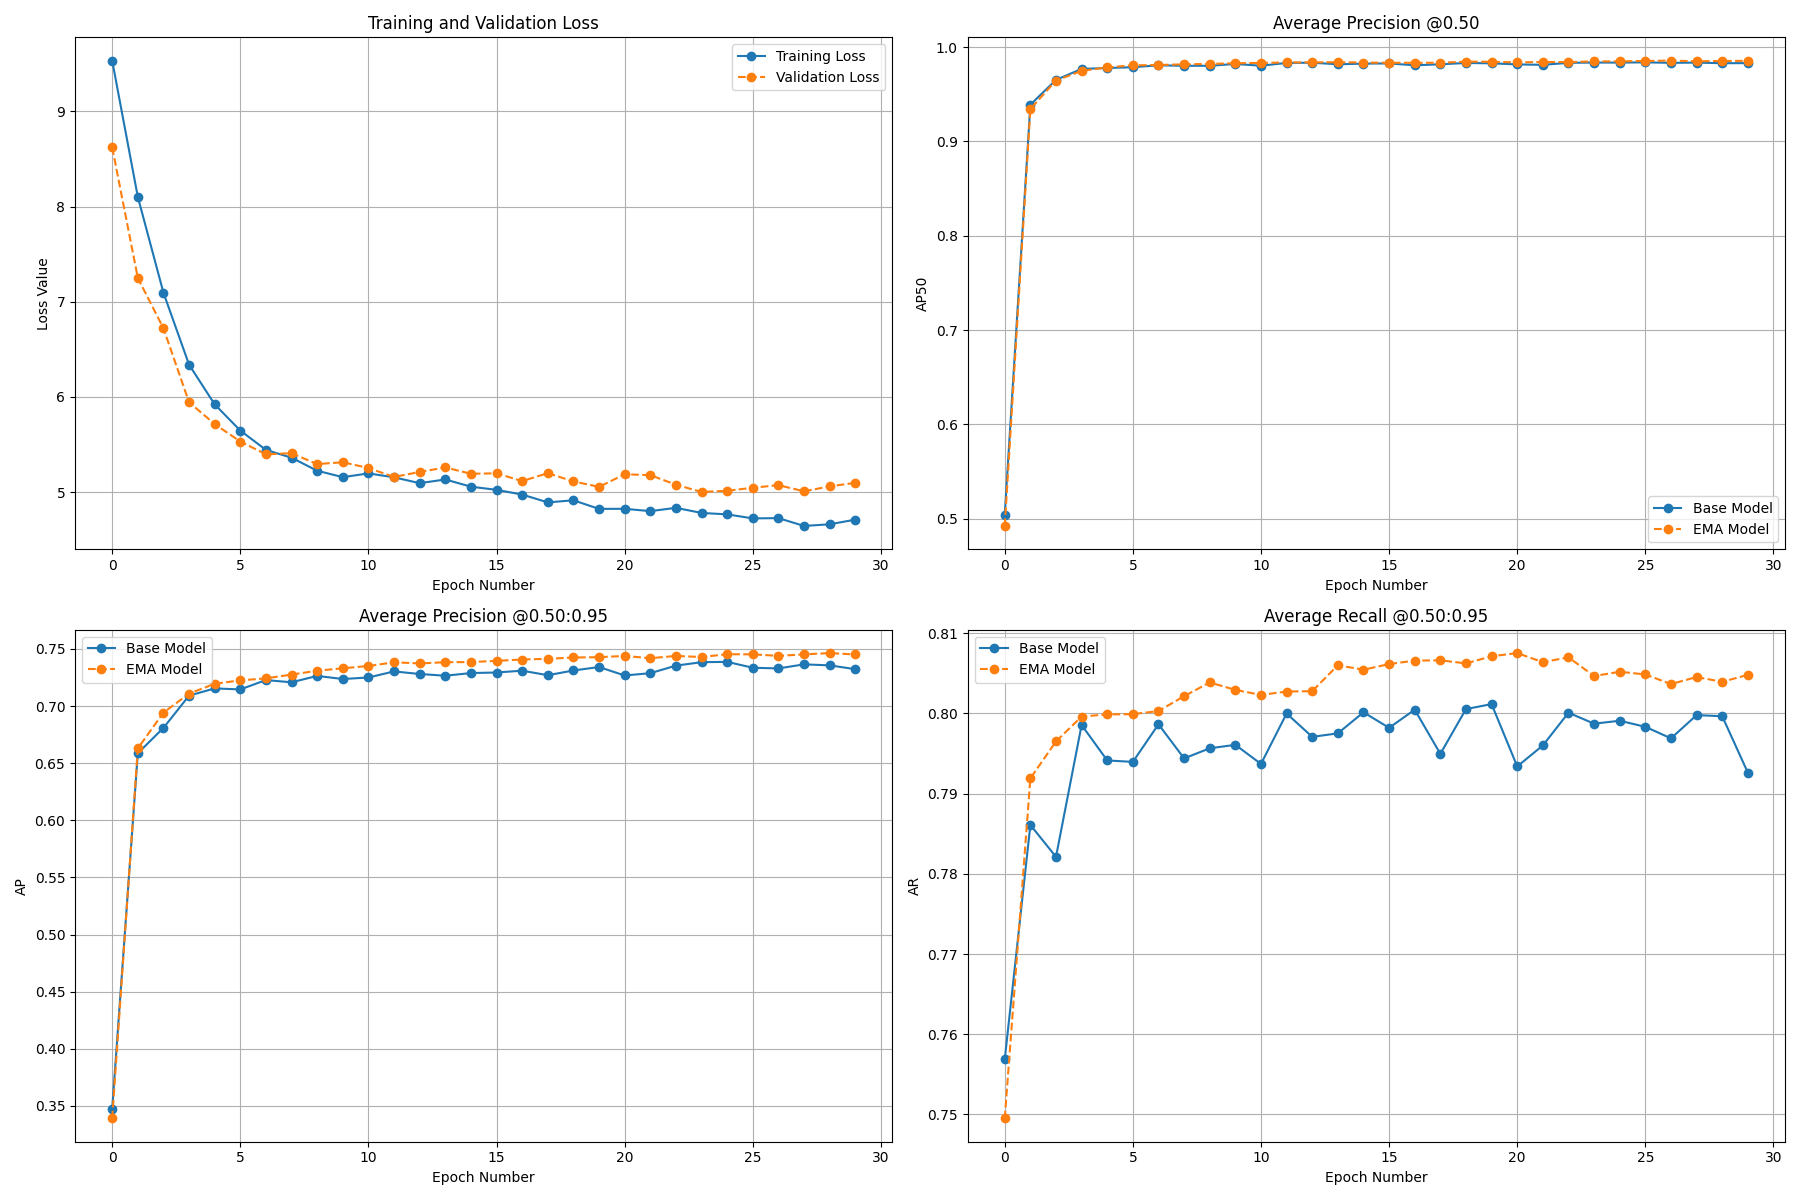

In [ ]:
from PIL import Image

Image.open("/content/output/metrics_plot.png")

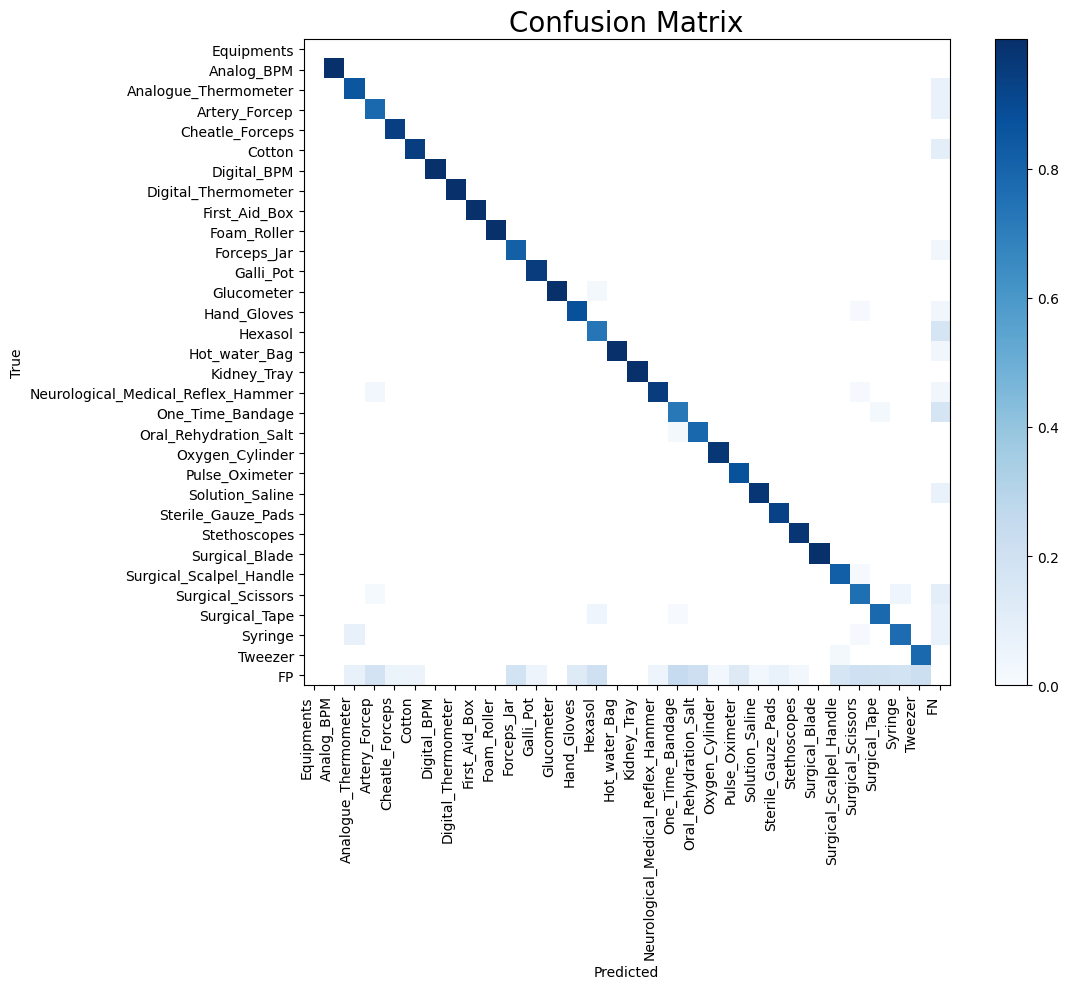

Saved to /content/output/confusion_matrix.png


In [ ]:
# --- Confusion Matrix for RF-DETR on COCO test split ---
import supervision as sv
import numpy as np

# thresholds you can tune
CONF_THRESHOLD = 0.25   # ignore low-confidence preds
IOU_THRESHOLD  = 0.50   # match preds to GT by IoU >= 0.5

# callback that returns sv.Detections for a given image
def _predict_detections(image: np.ndarray) -> sv.Detections:
    """
    Works with both RF-DETR local (.predict) and Inference API (.infer) styles.
    - model.predict(...) -> returns sv.Detections directly
    - model.infer(...)[0] -> wrap with sv.Detections.from_inference(...)
    """
    try:
        # local RF-DETR API (recommended after fine-tuning)
        # returns sv.Detections with .xyxy, .confidence, .class_id
        return model.predict(image, threshold=CONF_THRESHOLD)
    except AttributeError:
        # Inference engine style (pred object needs wrapping)
        pred = model.infer(image, confidence=CONF_THRESHOLD)[0]
        return sv.Detections.from_inference(pred)

# build confusion matrix by benchmarking the whole dataset via callback
cm = sv.ConfusionMatrix.benchmark(
    dataset=ds,
    callback=_predict_detections,
    conf_threshold=CONF_THRESHOLD,
    iou_threshold=IOU_THRESHOLD,
)

# plot + save (normalized to percentages; change normalize=False for raw counts)
fig = cm.plot(
    title=f"Confusion Matrix",
    normalize=True,
    save_path="/content/output/confusion_matrix.png"
)

# If you're in a notebook and want to see it inline too:
import matplotlib.pyplot as plt
plt.show()

print("Saved to /content/output/confusion_matrix.png")

In [ ]:
!ls -la /content/output

total 3013204
drwxr-xr-x 3 root root      4096 Sep 26 11:53 .
drwxr-xr-x 1 root root      4096 Sep 26 10:35 ..
-rw-r--r-- 1 root root 536485397 Sep 26 11:00 checkpoint0009.pth
-rw-r--r-- 1 root root 536485397 Sep 26 11:26 checkpoint0019.pth
-rw-r--r-- 1 root root 536485397 Sep 26 11:52 checkpoint0029.pth
-rw-r--r-- 1 root root 402396538 Sep 26 11:51 checkpoint_best_ema.pth
-rw-r--r-- 1 root root 402404758 Sep 26 10:52 checkpoint_best_regular.pth
-rw-r--r-- 1 root root 134098607 Sep 26 11:53 checkpoint_best_total.pth
-rw-r--r-- 1 root root 536475141 Sep 26 11:52 checkpoint.pth
drwxr-xr-x 2 root root      4096 Sep 26 10:37 eval
-rw-r--r-- 1 root root     13092 Sep 26 11:53 events.out.tfevents.1758882905.4765205e25b6.347.0
-rw-r--r-- 1 root root    457188 Sep 26 11:53 log.txt
-rw-r--r-- 1 root root    161797 Sep 26 11:53 metrics_plot.png
-rw-r--r-- 1 root root      8545 Sep 26 11:53 results.json


## Evaluate Fine-tuned RF-DETR Model

Before benchmarking the model, we need to load the best saved checkpoint. To ensure it fits on the GPU, we first need to free up GPU memory. This involves deleting any remaining references to previously used objects, triggering Python’s garbage collector, and clearing the CUDA memory cache.

In [ ]:
import gc
import torch
import weakref

def cleanup_gpu_memory(obj=None, verbose: bool = False):

    if not torch.cuda.is_available():
        if verbose:
            print("[INFO] CUDA is not available. No GPU cleanup needed.")
        return

    def get_memory_stats():
        allocated = torch.cuda.memory_allocated()
        reserved = torch.cuda.memory_reserved()
        return allocated, reserved

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[Before] Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

    # Ensure we drop all strong references
    if obj is not None:
        ref = weakref.ref(obj)
        del obj
        if ref() is not None and verbose:
            print("[WARNING] Object not fully garbage collected yet.")

    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    torch.cuda.synchronize()

    if verbose:
        alloc, reserv = get_memory_stats()
        print(f"[After]  Allocated: {alloc / 1024**2:.2f} MB | Reserved: {reserv / 1024**2:.2f} MB")

In [ ]:
cleanup_gpu_memory(model, verbose=True)

[Before] Allocated: 146.58 MB | Reserved: 20880.00 MB
[WARNING] Object not fully garbage collected yet.
[After]  Allocated: 146.58 MB | Reserved: 310.00 MB


We load the best-performing model from the `checkpoint_best_total.pth` file using the `RFDETRMedium` class. This checkpoint contains the trained weights from our most successful training run. After loading, we call `optimize_for_inference()`, which prepares the model for efficient inference.

In [ ]:
model = RFDETRMedium(pretrain_weights="/content/output/checkpoint_best_total.pth")
model.optimize_for_inference()

Using a different number of positional encodings than DINOv2, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.
Using patch size 16 instead of 14, which means we're not loading DINOv2 backbone weights. This is not a problem if finetuning a pretrained RF-DETR model.


reinitializing detection head with 30 classes


Loading pretrain weights


Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
torch.as_tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, thi

In [ ]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

In [ ]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 450/450 [00:11<00:00, 37.59it/s]


In [ ]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()
print(map_result)

Average Precision (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.740
Average Precision (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.981
Average Precision (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.891
Average Precision (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.479
Average Precision (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]                 = 0.623
Average Precision (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]                 = 0.761


## Run Inference with Fine-tuned RF-DETR Model

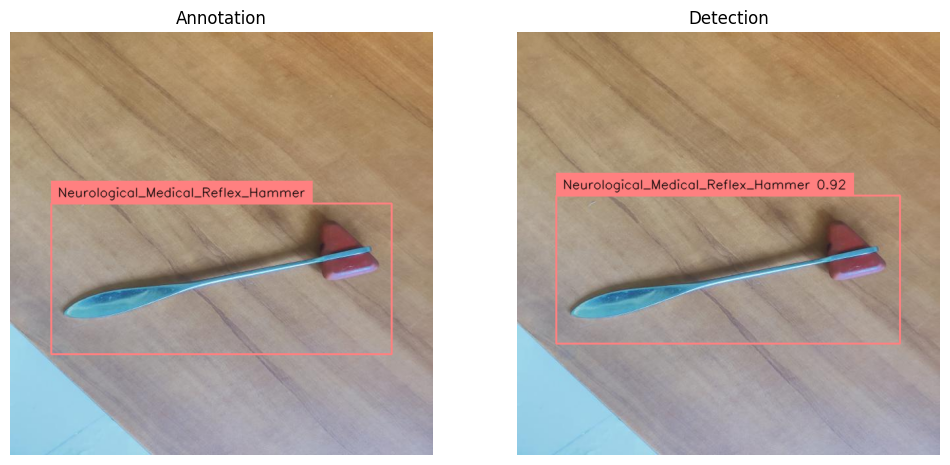

In [ ]:
from rfdetr import RFDETRBase
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

detections = model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)
color = sv.ColorPalette.from_hex([
    "#ffff00", "#ff9b00", "#ff66ff", "#3399ff", "#ff66b2", "#ff8080",
    "#b266ff", "#9999ff", "#66ffff", "#33ff99", "#66ff66", "#99ff00"
])

bbox_annotator = sv.BoxAnnotator(color=color,thickness=thickness)
label_annotator = sv.LabelAnnotator(
    color=color,
    text_color=sv.Color.BLACK,
    text_scale=text_scale)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])